# Teaching a Neural Network How to Write:  An MNIST Autoencoder

by Ken Leidal (ken@poshdevelopment.com)

After taking two machine learning related grad classes last semester (6.867 Machine Learning and 6.864 Advanced Natural Language Processing), I want to start a blog series in which I experiment with various ML-related techniques and interesting datasets.  Don't expect anything paper (or thesis) worthy, but expect me to geek out about cool applications of ML techniques and other side projects that pop up.  A lot of this will focus on learning and using popular ML frameworks too.  Right now the focus is on TensorFlow, since TF seems to be making a big splash in the ML community, especially in industry [1].  In this post, I'll focus on using TensorFlow on the MNIST dataset.  It's based on TensorFlow's ["MNIST for Beginners"](https://www.tensorflow.org/tutorials/mnist/beginners/) tutorial, but I'll take it a step farther and explore more interesting tasks than the classic digit classification problem.

## Introduction

An *autoencoder* is a model which, given an input, can reproduce that input.  Not too difficult, right?  Just feed the input directly into the output.  But oftentimes the models are constrained in such a way that there is an information bottleneck.  This means the model is forced to learn a dense, information packed representation of the input that allows it to recreate it.  This takes the form of a lossy compression to get get through the bottleneck, after which the input is approximated as best as possible.

For example, say Matt is an autoencoder.  Matt's job is to take a number I give him between 0 and 99, remember it, and say it back to me when I ask him what the number was later.  Now say Matt's memory is quite terrible, so he can only remember a digit from 0 to 9.  Matt might decide only to remember the tens digit of the number, and then guess 4 or 5 for the ones digit as a "close enough" approximation of the original input.  Maybe after a few examples Matt suspects that I only give numbers with a 1 in the one's digit, so he updates his output bias to say 1 for the ones digit each time.  This is a basic example of the autoencoding problem.

In reality, the inputs aren't usually so simple.  Autoencoders are often used as a tool in machine translation, where the input is an arbitrarily long sequence of words and the task is to represent the entire sequence and be able to recreate it based on a vector of fixed, finite dimensions.  You can imagine that from an information theoretical perspective, this is impossible (since there are infinite input sequences, but only finite vectors when using floating point arithmetic).
In our case, the inputs are images of handwritten digits (0, 1, 2, 3, 4, 5, 6, 7, 8, 9) from the MNIST dataset. 

So how is autoencoding different than compression?  Can't we just use existing compression algorithms?  Well, in the case of neural networks, the idea isn't to compress the input to the least number of bits possible, it's to take sparse data and boil it down to the essential information that is useful for solving the problem at hand.  In the case of autoencoders, the problem at hand is reproducing the input, but that doesn't need to be the task.  Later we explore how using a hyperparameter to tune the tradeoff between two objectives changes the information representation in the bottleneck.

In this post, we briefly overview MNIST and a simple neural model for digit classification (i.e. given an image, which digit is it portraying?).  Then we look at an interesting extention of this neural model:  adding two additional layers and tweaking the loss function to create an autoencoder in which the digit's classification is the information bottleneck.  This latter half of the neural net (the decoder) can then be used to organically produce an image of a given digit (i.e. the neural network's "ideal conception" of what the number should look like).

## The Dataset:  MNIST

MNIST is a labeled dataset consisting of 28x28 grayscale images of digits with 8-bit pixels (taking values from 0 to 255).  The dataset was created from scans of handwritten zip codes on postal mail.   The dataset is commonly used as a toy dataset for ML models (especially neural models).

We used TensorFlow's `tensorflow.examples.tutorials.mnist` module to make loading and batching the training examples easy [1].  Here are some basic stats on the dataset to give you an idea of what it looks like:

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
mnist = input_data.read_data_sets('MNIST_data', one_hot=False)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
print("%d training points total" % len(mnist.train.labels))
print("%d test points total" % len(mnist.test.labels))

55000 training points total
10000 test points total


In [6]:
print("Max pixel value: %.3f" % np.max(mnist.train.images))
print("Min pixel value: %.3f" % np.min(mnist.train.images))

Max pixel value: 1.000
Min pixel value: 0.000


In [3]:
train_label_counts = [sum((1 for label in mnist.train.labels if label == digit)) for digit in xrange(10)]
test_label_counts = [sum((1 for label in mnist.test.labels if label == digit)) for digit in xrange(10)]

In [4]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

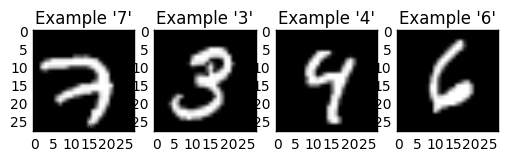

In [11]:
cols = 4
gs = gridspec.GridSpec(1, cols)
for i in xrange(cols):
    ax = plt.subplot(gs[0, i])
    ax.imshow(np.reshape(mnist.train.images[i], [28, 28]), cmap='gray')
    ax.set_title("Example '%d'" % mnist.train.labels[i])
plt.show()

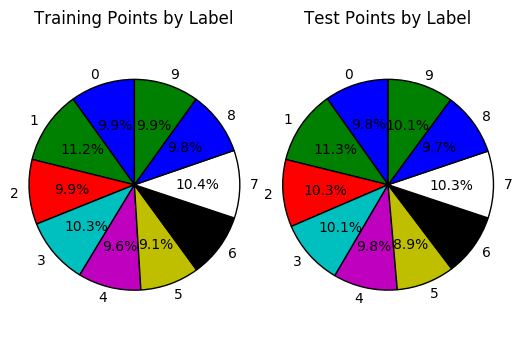

In [9]:
gs = gridspec.GridSpec(1, 2)

ax = plt.subplot(gs[0, 0])
ax.set_title("Training Points by Label")
ax.pie(train_label_counts, labels=[str(d) for d in xrange(10)], autopct='%1.1f%%', shadow=False, startangle=90)
ax.axis('equal')


ax = plt.subplot(gs[0, 1])
ax.set_title("Test Points by Label")
ax.pie(test_label_counts, labels=[str(d) for d in xrange(10)], autopct='%1.1f%%', shadow=False, startangle=90)
ax.axis('equal')

plt.show()

## Digit Classification:  A Simple Neural Model

Let's start by making a simple feed-forward neural network in TensorFlow [1].  It's only three layers:  an 784 unit input layer (one unit for every pixel of the 28x28 grayscale image), a 16 unit ReLu hidden layer, and a 10 unit softmax output layer (a probability distribution over the 10 digits).  Here's a graphical representation:

<img src="images/tfgraph-class-alone.png"/>

The three layers are the boxes in the lower left:  the `inputs` layer, `hidden` layer, and `class-output` layer.  Expanding these boxes, you can take a look at some of the operations going on inside the network:

<img src="images/tfgraph-class-alone-expanded.png"/>

These graphical visualizations were created using TensorBoard.  I find them to be much more visually representative of the network than the numerous equations usually used to represent a neural net.  You can see the matrix multiplication of the weights with the input to a layer, the adding in of the biases, and the use of an activation function (like ReLu or softmax).

For the loss function for the digit classification task, we use cross entropy loss:
$$L_{\text{classification}}(\mathcal{D}) = - \frac{1}{|\mathcal{D}|} \sum_{(x, y) \in \mathcal{D}} \sum_{d \in \text{Digits}} y_d \log \left( f(x)_d \right) $$
where $\mathcal{D}$ is the dataset, $x$ is the image, $y$ is a one-hot encoding of the digit, and $f(x)$ is the softmax output of the neural network.
It's not important to understand this equaiton; just know that it basically just drives the output probability distribution to be a one-hot vector of the correct digit label.
That is, for an image of a 2, cross entropy loss drives the output of the network to approach:
$[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]$. For an image of a 0, cross entropy loss drives the output of the network to approach: $[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]$.

Training for 70 epochs with a batch size of 100 images and an Adam optimizer with a learning rate of 0.01, I get 98.1% training accuracy and 95.3% test accuracy, which is reasonable for a simple feed-forward model.

But this is standard.  It's only a small step up from TensorFlow's ["MNIST for Beginners"](https://www.tensorflow.org/tutorials/mnist/beginners/) tutorial (I added a ReLu hidden layer) [1].  So what?  Well, let's try autoencoding the images too.


## Combining the Tasks of Digit Classification and Autoencoding Image Inputs

So how do we turn our network into an autoencoder?  Well, we could just add another ReLu hidden layer and then a 784 unit linear output layer to the back of our existing network.  This makes the previous `class-output` softmax layer an intermediate hidden layer, in a sense.  Having a softmax layer as an intermediate layer is a little non-conventional, but I think it's interesting, because it allows us to have a combined objective:  reproduce the input images AND learn the digit classification for the images.  We can do this using a weighted loss function:
$$L_{\text{total}}(\mathcal{D}) = \alpha L_{\text{classification}}(\mathcal{D}) + (1 - \alpha) L_{\text{autoencoding}}(\mathcal{D})$$
where $\alpha$ is between 0 and 1 and $L_{\text{autoencoding}}(\mathcal{D})$ is the mean-squared error of the pixels in the output (as compared to their corresponding pixels in the input):
$$L_{\text{autoencoding}}(\mathcal{D}) = \frac{1}{|\mathcal{D}|} \sum_{(x, y) \in \mathcal{D}} \frac{1}{784} \sum_{j=1}^{784} (g(x^{(i)})_j - x^{(i)}_j)^2 $$
Graphically, the network looks like:

<img src="images/tfgraph.png"/>

For $\alpha = 1$, the network is the same as the original (it is only trained to solve the digit classification problem).  For $\alpha = 0$, the network is solely an autoencoder, paying no attention for the digit classification problem.  Interestingly, if $\alpha = 0$, the network is trained entirely independent of the labels of the images.

If $0 < \alpha < 1$, the network is trained to be able to predict the digit classification AND use this probabiltiy distribution over digits to then reproduce the image input.  That is, the probability distribution over digits is the autoencoder's information bottleneck, having only 10 units whereas the other hidden layers have 16.  What this allows us to do is to remove the encoder post-training and set the `class-output` layer to a one-hot encoding of a particular digit and see what image the decoder produces.  The images produced are entirely encoded by the trained weights and biases in the decoder.  In layman's terms, they're what the net thinks each digit should look like.  For $\alpha = 0.9$, the "ideal" digits produced by setting the `class-output` layer to one-hot encodings of the digits post-training are:

<img src="images/autoencodings.png"/>

Interestingly, the network still performs almost just as well on the digit classification task: training accuracy was roughly 97.7% and test accuracy was 95.2% on the digit classification task (even with the combined objective).  Over the 100 epochs of training, training loss looked like:

<img src="images/training_loss.png"/>

showing that total loss mostly depends on digit classification loss for $\alpha = 0.9$.  As a result, the gradients in the encoder are dominated by classification loss and only the decoder is significantly affected by autoencoding loss.

If we don't care what the encoding for the information bottleneck is at all and we only care about autoencoding accuracy, we can set $\alpha = 0$.  If we repeat the same experiment and manually set the class-output layer after training to see what images are produce, we observe the following:

<img src="images/autoencoder-only.png"/>

Completely nonsensical (by human standards).  This is explained by the fact that the loss function at $\alpha = 0$ no longer drives one-hot vectors in the `class-output` layer to be meaningful.  That is, for autoencoding accuracy, it's more useful to use a weighted combination of multiple units of the `class-output` layer rather than depending primarily on one.  Intuitively, this makes sense, because a choice of any arbitrary 10-class probability distribution allows for many combinations (and much more information) than a choice of one of 10 one-hot vectors.

$\alpha$ can be thought of as a hyperparameter which tunes the extent to which we are forcing the information bottleneck to encode the digit classes.
Take a look at the difference in the histograms of the softmax outputs for $\alpha = 0$ and $\alpha = 0.9$:
<table>
<tr>
<td style="text-align: center"><img src="images/autoencoder-only-softmax-out.png">$\alpha = 0$</td><td style="text-align: center"><img src="images/alpha0.9-softmax-out.png">$\alpha = 0.9$</td>
</tr>
</table>
As you can see, the output of the softmax layer is driven to output $1$'s and $0$'s (i.e. one-hot vectors) when cross-entropy loss for digit classification is taken into account ($\alpha > 0$).  In contrast, for $\alpha = 0$, the weights are distributed with mean near the uniform distribution over the 10 classes.

## Conclusion

Information representation at the bottleneck of auto-encoders is quite interesting.  I took an MNIST autoencoder, and used a hyperparameter to constrain the intermediate representation.  Unconstrained ($\alpha = 0$), the representation at the bottleneck had little semantic validity but was fine-tuned to be able to reproduce the input when decoded.  Constrained ($\alpha > 0$), the intermediate representation was driven to be a one-hot encoding of the digit.  It's a tradeoff between performance (reproduce the input as best as possible) and understandability (encoding to a digit, then generating an image corresponding to the digit).  I suspect that this technique might be useful in breaking the black box while analyzing other simple neural architectures.

## References

[1] Martín Abadi, Ashish Agarwal, Paul Barham, Eugene Brevdo,
Zhifeng Chen, Craig Citro, Greg S. Corrado, Andy Davis,
Jeffrey Dean, Matthieu Devin, Sanjay Ghemawat, Ian Goodfellow,
Andrew Harp, Geoffrey Irving, Michael Isard, Rafal Jozefowicz, Yangqing Jia,
Lukasz Kaiser, Manjunath Kudlur, Josh Levenberg, Dan Mané, Mike Schuster,
Rajat Monga, Sherry Moore, Derek Murray, Chris Olah, Jonathon Shlens,
Benoit Steiner, Ilya Sutskever, Kunal Talwar, Paul Tucker,
Vincent Vanhoucke, Vijay Vasudevan, Fernanda Viégas,
Oriol Vinyals, Pete Warden, Martin Wattenberg, Martin Wicke,
Yuan Yu, and Xiaoqiang Zheng.
TensorFlow: Large-scale machine learning on heterogeneous systems, 2015. Software available from tensorflow.org.